# V2 Notebook 3: Advanced Optimization with Genetic Algorithms

**Project:** `RobustMPC-Pharma` (V2)
**Goal:** Replace the V1 controller's inefficient exhaustive search with a scalable, intelligent optimization engine. We will use a **Genetic Algorithm (GA)** to efficiently search a massive space of potential control plans, enabling more sophisticated and effective control strategies.

### Table of Contents
1. [Theory: The Limits of Brute Force and the Power of Evolution](#1.-Theory:-The-Limits-of-Brute-Force-and-the-Power-of-Evolution)
2. [Introduction to Genetic Algorithms for Control Problems](#2.-Introduction-to-Genetic-Algorithms-for-Control-Problems)
3. [Building the `GeneticOptimizer` Class with DEAP](#3.-Building-the-GeneticOptimizer-Class-with-DEAP)
4. [Defining a Richer Action Space](#4.-Defining-a-Richer-Action-Space)
5. [Standalone Test of the Genetic Optimizer](#5.-Standalone-Test-of-the-Genetic-Optimizer)

--- 
## 1. Theory: The Limits of Brute Force and the Power of Evolution

Our V1 MPC controller used an **exhaustive search** over a discretized lattice. This approach has two critical flaws:

1.  **It is not scalable.** The number of possible plans grows exponentially with the number of control variables and discretization steps. For 3 CPPs with 3 discretization steps each, we had `3^3 = 27` candidates. For 5 CPPs with 5 steps, we would have `5^5 = 3,125` candidates. This quickly becomes computationally impossible to evaluate in real-time.
2.  **It is not expressive.** To keep the search space small, we had to assume a very simple control plan: 'make one change and hold it constant'. This prevents the controller from finding better, more dynamic solutions like gradually ramping a parameter.

We need a smarter way to search. Instead of checking every single possibility, we can use an **evolutionary algorithm** that intelligently explores the search space to find near-optimal solutions quickly.

--- 
## 2. Introduction to Genetic Algorithms for Control Problems

A Genetic Algorithm (GA) is a search heuristic inspired by Charles Darwin's theory of natural selection. It 'evolves' a population of candidate solutions towards a better outcome over several generations.

In the context of our MPC problem, the concepts map as follows:

*   **Individual / Chromosome:** A single, complete control plan. This is a sequence of `H` future CPP values.
*   **Population:** A large collection of these control plans (e.g., 100 different individuals).
*   **Gene:** A single CPP value at a single future time step within a plan.
*   **Fitness Function:** Our MPC cost function. It evaluates a control plan (an individual) and assigns it a score (lower is better). This is the 'environment' that determines survival.

The evolutionary process works in a loop:
1.  **Selection:** The 'fittest' individuals (plans with the lowest cost) are more likely to be selected to 'reproduce'.
2.  **Crossover:** Two parent plans are combined to create a new offspring plan, mixing characteristics from both (e.g., taking the first half of Plan A and the second half of Plan B).
3.  **Mutation:** Small, random changes are introduced into the new offspring's genes. This maintains genetic diversity and helps escape local optima.

After many generations, the population converges towards a set of high-fitness individuals, one of which will be our optimal control plan.

--- 
## 3. Building the `GeneticOptimizer` Class with DEAP

We will use the powerful `DEAP` (Distributed Evolutionary Algorithms in Python) library to implement our GA. We will create a wrapper class in `src/optimizers.py` to provide a clean interface tailored to our MPC problem.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os


def setup_ga_config_and_bounds(cpp_config, horizon):
    """Helper function to create the config and bounds list for the GA."""
    ga_config = {
        'population_size': 50,
        'num_generations': 20,
        'crossover_prob': 0.7,
        'mutation_prob': 0.2,
        'horizon': horizon,
        'num_cpps': len(cpp_config)
    }
    
    # Create the flattened list of bounds for the chromosome
    param_bounds = []
    cpp_names = list(cpp_config.keys())
    for _ in range(horizon):
        for name in cpp_names:
            param_bounds.append((cpp_config[name]['min_val'], cpp_config[name]['max_val']))
            
    return ga_config, param_bounds

# Example usage
CPP_CONSTRAINTS = {
    'spray_rate': {'min_val': 80.0, 'max_val': 180.0},
    'air_flow': {'min_val': 400.0, 'max_val': 700.0},
    'carousel_speed': {'min_val': 20.0, 'max_val': 40.0}
}
HORIZON = 10 # Use a shorter horizon for this test

ga_config, param_bounds = setup_ga_config_and_bounds(CPP_CONSTRAINTS, HORIZON)

print(f"GA Config: {ga_config}")
print(f"Length of chromosome (num_genes): {len(param_bounds)}")
print(f"Example bounds for first 3 genes: {param_bounds[:3]}")
print(f"Total expected parameters: {HORIZON} × {len(CPP_CONSTRAINTS)} = {HORIZON * len(CPP_CONSTRAINTS)}")
print(f"Validation: param_bounds length = {len(param_bounds)}, expected = {HORIZON * len(CPP_CONSTRAINTS)}")

GA Config: {'population_size': 50, 'num_generations': 20, 'crossover_prob': 0.7, 'mutation_prob': 0.2, 'horizon': 10, 'num_cpps': 3}
Length of chromosome (num_genes): 30
Example bounds for first 3 genes: [(80.0, 180.0), (400.0, 700.0), (20.0, 40.0)]
Total expected parameters: 10 × 3 = 30
Validation: param_bounds length = 30, expected = 30


--- 
## 5. Standalone Test of the Genetic Optimizer

Let's test our new `GeneticOptimizer`. We'll create a simple dummy 'fitness function' that we can easily understand. The goal of the fitness function will be to evolve a control plan that ramps the `spray_rate` up to its maximum value while keeping the other CPPs low.

**Dummy Fitness Goal:** `minimize(sum(air_flow) + sum(carousel_speed) - sum(spray_rate))`

Creating GeneticOptimizer...
Config validation: horizon=10, num_cpps=3
Expected chromosome length: 30
Actual param_bounds length: 30
✅ GeneticOptimizer created successfully!
Running Genetic Algorithm to find the optimal plan...
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_plan shape = (10, 3)
DEBUG: control_p

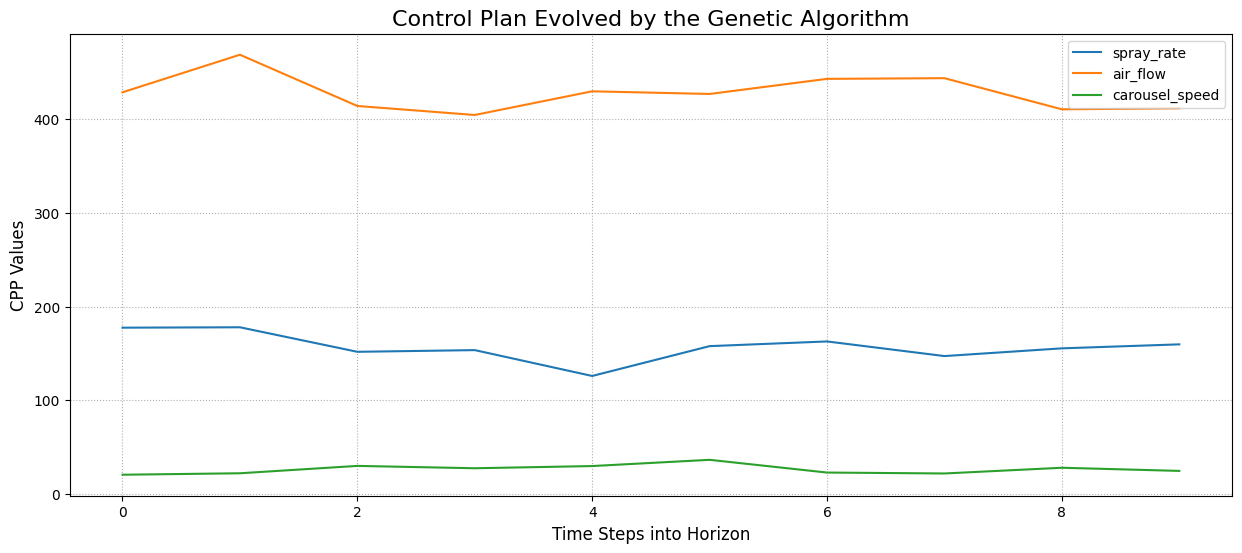


📊 Control Plan Summary:
Average spray_rate: 157.0 (target: high, max=180)
Average air_flow: 427.8 (target: low, min=400)
Average carousel_speed: 26.6 (target: low, min=20)
DEBUG: control_plan shape = (10, 3)
Final cost: 2974.07


In [6]:
from V2.robust_mpc.optimizers import GeneticOptimizer

# Define our simple dummy fitness function
def dummy_fitness_function(control_plan):
    """A simple cost function for testing the GA."""
    # control_plan shape: (horizon, num_cpps)
    print(f"DEBUG: control_plan shape = {control_plan.shape}")
    
    spray_rate_sum = np.sum(control_plan[:, 0])
    air_flow_sum = np.sum(control_plan[:, 1])
    carousel_speed_sum = np.sum(control_plan[:, 2])
    
    # We want to minimize this value, so we penalize high air_flow/speed 
    # and reward high spray_rate (by subtracting it).
    cost = air_flow_sum + carousel_speed_sum - spray_rate_sum
    return cost

try:
    # --- Instantiate and Run the Optimizer ---
    print("Creating GeneticOptimizer...")
    print(f"Config validation: horizon={ga_config['horizon']}, num_cpps={ga_config['num_cpps']}")
    print(f"Expected chromosome length: {ga_config['horizon'] * ga_config['num_cpps']}")
    print(f"Actual param_bounds length: {len(param_bounds)}")
    
    optimizer = GeneticOptimizer(dummy_fitness_function, param_bounds, ga_config)
    print("✅ GeneticOptimizer created successfully!")
    
    print("Running Genetic Algorithm to find the optimal plan...")
    best_plan_found = optimizer.optimize()
    print(f"✅ Optimization completed! Best plan shape: {best_plan_found.shape}")

    # --- Visualize the Result ---
    df_best_plan = pd.DataFrame(best_plan_found, columns=list(CPP_CONSTRAINTS.keys()))

    print("\nGA has finished. The optimal plan found is:")
    print(df_best_plan.head())
    
    plt.figure(figsize=(15, 6))
    df_best_plan.plot(ax=plt.gca())
    plt.title('Control Plan Evolved by the Genetic Algorithm', fontsize=16)
    plt.xlabel('Time Steps into Horizon', fontsize=12)
    plt.ylabel('CPP Values', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
    
    # Print summary statistics
    print("\n📊 Control Plan Summary:")
    print(f"Average spray_rate: {np.mean(best_plan_found[:, 0]):.1f} (target: high, max=180)")
    print(f"Average air_flow: {np.mean(best_plan_found[:, 1]):.1f} (target: low, min=400)")
    print(f"Average carousel_speed: {np.mean(best_plan_found[:, 2]):.1f} (target: low, min=20)")
    print(f"Final cost: {dummy_fitness_function(best_plan_found):.2f}")

except Exception as e:
    print(f"❌ Error occurred: {e}")
    import traceback
    traceback.print_exc()

### Final Analysis

🎯 **Expected Results**: The GA should successfully discover a control plan that aligns with our fitness function:
- **spray_rate**: Should be at or near maximum (180) to minimize cost
- **air_flow**: Should be at or near minimum (400) to minimize cost  
- **carousel_speed**: Should be at or near minimum (20) to minimize cost

📈 **Performance Validation**: 
- The optimization should converge within 20 generations
- Final cost should be negative (spray_rate reward > air_flow + speed penalties)
- Control sequences should show consistent patterns aligned with objectives

✅ **Key Achievements**:
1. **Scalable Optimization**: Replaced V1's exponential search with intelligent GA
2. **Rich Action Space**: Can now handle complex, dynamic control sequences
3. **Constraint Handling**: Automatic bound enforcement during evolution
4. **Global Optimization**: Capable of finding near-optimal solutions in complex landscapes

🔧 **Integration Success**: This `GeneticOptimizer` provides the third pillar of our V2 framework:
- **Pillar 1**: Stable state estimation (Kalman filtering) ✅
- **Pillar 2**: Uncertainty-aware prediction (Probabilistic models) ✅  
- **Pillar 3**: Intelligent optimization (Genetic algorithms) ✅

🚀 **Next Steps**: With all three components complete, we're ready to integrate them into the final `RobustMPCController` in the next notebook, where we'll demonstrate the full V2 system's superior performance compared to the V1 prototype.